In [1]:
# Import required dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.insert(0, parent_dir)

# Import custom modules
import packer
import evaluator

# create instances
GPU_TYPES = ["DGX-B300", "H200", "Rubin-NVL144", "H800", "H20"]
packer = packer.Packer(GPU_TYPES, gpu_info_file='../device/gpu_info.csv')

# define trace pdf evaluator
trace_pdf = evaluator.load_trace_pdf("../traces/generated_trace_pdf.csv")

# Configure matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# constants
FIGURE_SAVE_LOCATION = "../data/figures/05evaluate/"
FIGURE_PREFILE = "inner_"

In [2]:
# define test inventories
test_inventories = [
    {
        "name": "homogeneous",
        "title": "(a) Homogeneous Same Size",
        "GPUs": {
            "DGX-B300": [32, 32, 32, 32, 32, 32, 32, 32],
        }
    },
    {
        "name": "homogeneous-different",
        "title": "(b) Homogeneous Different Sizes",
        "GPUs": {
            "DGX-B300": [32, 32, 16, 16, 16, 16, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
        }
    },
    {
        "name": "heterogeneous-same",
        "title": "(c) Heterogeneous Same Size",
        "GPUs": {
            "DGX-B300": [32, 32],
            "Rubin-NVL144": [32, 32],
            "H800": [32, 32],
            "H20": [32, 32],
        }
    },
    {
        "name": "heterogeneous-different",
        "title": "(d) Heterogeneous Different Sizes",
        "GPUs": {
            "DGX-B300": [32, 16, 8, 4, 4],
            "Rubin-NVL144": [32, 16, 8, 4, 4],
            "H200": [8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4],
            "H20": [8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4],
        }
    },
]

# for each inventory, pack the GPUs
for inventory in test_inventories:
    # extract islands from the inventory
    island_config = inventory["GPUs"]

    # create islands based on the configuration
    islands = []
    for gpu_type, sizes in island_config.items():
        for idx, size in enumerate(sizes):
            new_island = evaluator.Island(
                id=f"{gpu_type}_{idx}",
                gpu_type=gpu_type,
                size=size,
            )
            islands.append(new_island)
    islands = {island.id: island for island in islands}

    # print the islands for debugging
    print(f"Islands for inventory {inventory['name']}:")
    for island in islands.values():
        print(f"  {island.id}: {island.gpu_type} with size {island.size}")
    print("")

    # sum up the total number of GPUs
    total_gpus = sum(island.size for island in islands.values())
    print(f"Total GPUs in inventory {inventory['name']}: {total_gpus}")

    # pack the GPUs
    print(f"Packing inventory: {inventory['name']}")
    model, prefill_throughput, decode_throughput, delta, objective = packer.solve_linear(islands, trace_pdf, resolution=100, print_debug=False)

    if prefill_throughput is None or decode_throughput is None:
        exit(1)
    else:
        overall_throughput = min(prefill_throughput, decode_throughput)

    # check if the model is not None
    if model is not None:
        # save the model
        packer.save_model(model, islands, f"eval_{inventory['name']}", path="../data/inner")

         # add the bins to the islands
        new_islands = packer.add_bins_to_islands(model, islands)

        # pass to evaluator
        sys_evaluator = evaluator.Evaluator(GPU_TYPES, gpu_info_file='../device/gpu_info.csv')
        prefill_throughput, decode_throughput = sys_evaluator.evaluate(new_islands, trace_pdf, f"eval_{inventory['name']}", print_debug=False, path="../data/inner")



Islands for inventory homogeneous:
  DGX-B300_0: DGX-B300 with size 32
  DGX-B300_1: DGX-B300 with size 32
  DGX-B300_2: DGX-B300 with size 32
  DGX-B300_3: DGX-B300 with size 32
  DGX-B300_4: DGX-B300 with size 32
  DGX-B300_5: DGX-B300 with size 32
  DGX-B300_6: DGX-B300 with size 32
  DGX-B300_7: DGX-B300 with size 32

Total GPUs in inventory homogeneous: 256
Packing inventory: homogeneous

=== Packer ===
*** Forming Ranges ***
*** Prefill GPU Config ***
*** Decode GPU Config ***
*** Creating Problem ***
*** Solving Problem ***

=== Overall Stats ===
  Prefill Throughput: 100.8087 requests/s
  Decode Throughput: 218.8031 requests/s
  Total Deviation: 119.4508
  Objective: -11336.8748
Islands for inventory homogeneous-different:
  DGX-B300_0: DGX-B300 with size 32
  DGX-B300_1: DGX-B300 with size 32
  DGX-B300_2: DGX-B300 with size 16
  DGX-B300_3: DGX-B300 with size 16
  DGX-B300_4: DGX-B300 with size 16
  DGX-B300_5: DGX-B300 with size 16
  DGX-B300_6: DGX-B300 with size 8
  DGX-B3

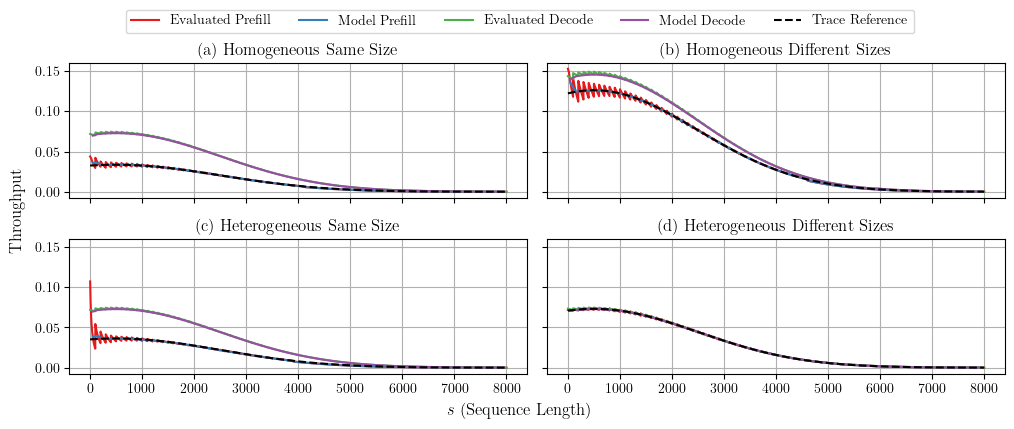

In [3]:
# Set color cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set1(np.linspace(0, 1, 10)))

# Load the trace PDF
trace_df = pd.read_csv("../traces/generated_trace_pdf.csv")

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot for each inventory
for i, inventory in enumerate(test_inventories):
    # Eval prefill and decode throughput
    eval_prefill_throughput_df = pd.read_csv(f"../data/inner/eval_{inventory['name']}/eval_prefill_throughput.csv")
    eval_decode_throughput_df = pd.read_csv(f"../data/inner/eval_{inventory['name']}/eval_decode_throughput.csv")

    # Model prefill and decode throughput
    model_prefill_throughput_df = pd.read_csv(f"../data/inner/eval_{inventory['name']}/model_prefill_throughput.csv")
    model_decode_throughput_df = pd.read_csv(f"../data/inner/eval_{inventory['name']}/model_decode_throughput.csv")

    # Calculate bin width for both prefill and decode throughput
    bin_width = model_prefill_throughput_df["Sequence"][1] - model_prefill_throughput_df["Sequence"][0]

    # Select the subplot
    ax = axes[i // 2, i % 2]

    # sum throughput of prefill and decode
    total_decode_throughput = eval_prefill_throughput_df["Throughput"].sum()
    total_prefill_throughput = eval_decode_throughput_df["Throughput"].sum()

    # pick the lowest throughput
    overall_throughput = min(total_decode_throughput, total_prefill_throughput)

    # Plot distribution of throughput as a probability density function, and compare it to the trace PDF
    ax.plot(eval_prefill_throughput_df["Sequence"], eval_prefill_throughput_df["Throughput"], label="Evaluated Prefill")
    ax.plot(model_prefill_throughput_df["Sequence"], model_prefill_throughput_df["Throughput"]  / bin_width, label="Model Prefill")
    ax.plot(eval_decode_throughput_df["Sequence"], eval_decode_throughput_df["Throughput"] , label="Evaluated Decode")
    ax.plot(model_decode_throughput_df["Sequence"], model_decode_throughput_df["Throughput"] / bin_width, label="Model Decode")
    ax.plot(trace_df["Length"], trace_df["Probability"] * overall_throughput, label="Trace Reference", color='black', linestyle='--')
    ax.set_title(inventory['title'])
    ax.grid()

# Add shared labels
fig.text(0.5, -0.01, r'$s$ (Sequence Length)', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a single legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}trace_throughput.pdf", bbox_inches='tight')

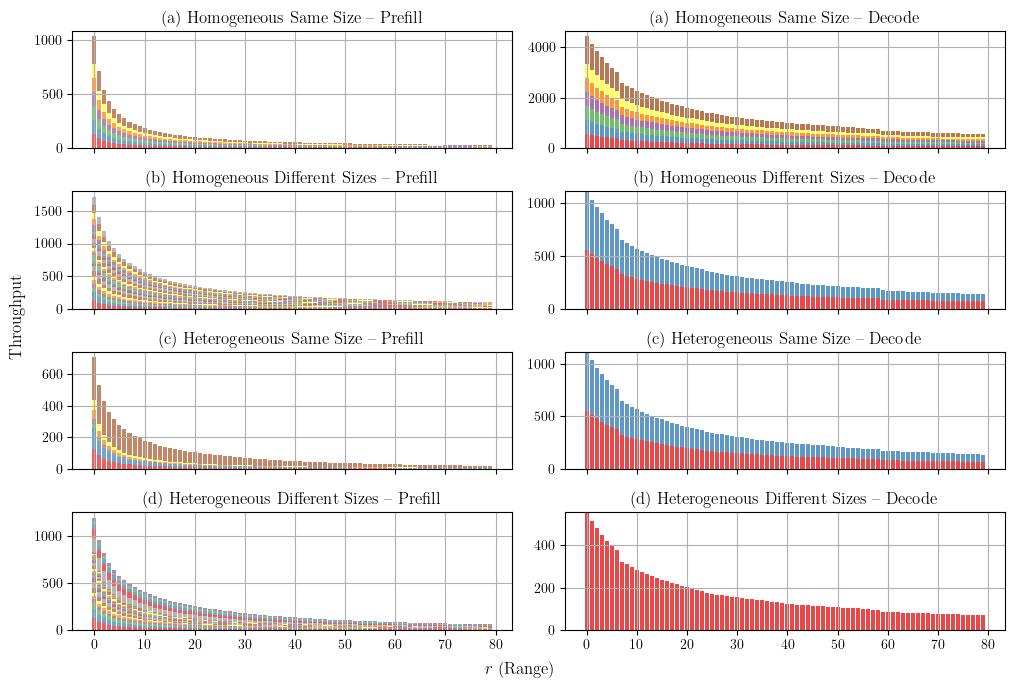

In [4]:
# Create a 4x2 subplot figure
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(10, 7))

for idx, inventory in enumerate(test_inventories):
    # 1) Read your CSV for this inventory
    assignment_df = pd.read_csv(f"../data/inner/eval_{inventory['name']}/model_assignment.csv")

    # 2) Make pivot tables
    prefill_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Prefill_Benchmark',
        aggfunc='sum',
        fill_value=0
    )
    decode_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Decode_Benchmark',
        aggfunc='sum',
        fill_value=0
    )

    # 3) Count islands and set color cycle
    num_islands = len(prefill_df.columns)
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=plt.cm.gist_rainbow(np.linspace(0, 1, num_islands))
    )

    x = prefill_df.index  # the Range values

    # 4a) Plot “Prefill” in column 0 of row idx
    ax_prefill = axes[idx, 0]
    bottom = None
    for isl in prefill_df.columns:
        ax_prefill.bar(x, prefill_df[isl], bottom=bottom, label=isl, alpha=0.7)
        bottom = prefill_df[isl] if bottom is None else bottom + prefill_df[isl]
    ax_prefill.set_title(f"{inventory['title']} – Prefill")
    ax_prefill.grid(True)

    # 4b) Plot “Decode” in column 1 of row idx
    ax_decode = axes[idx, 1]
    bottom = None
    for isl in decode_df.columns:
        ax_decode.bar(x, decode_df[isl], bottom=bottom, label=isl, alpha=0.8)
        bottom = decode_df[isl] if bottom is None else bottom + decode_df[isl]
    ax_decode.set_title(f"{inventory['title']} – Decode")
    ax_decode.grid(True)

fig.text(0.5, -0.01, r'$r$ (Range)', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}benchmark_all_inventories.pdf", bbox_inches='tight')
plt.show()

Number of islands in inventory homogeneous: 8
Number of islands in inventory homogeneous-different: 30
Number of islands in inventory heterogeneous-same: 8
Number of islands in inventory heterogeneous-different: 34


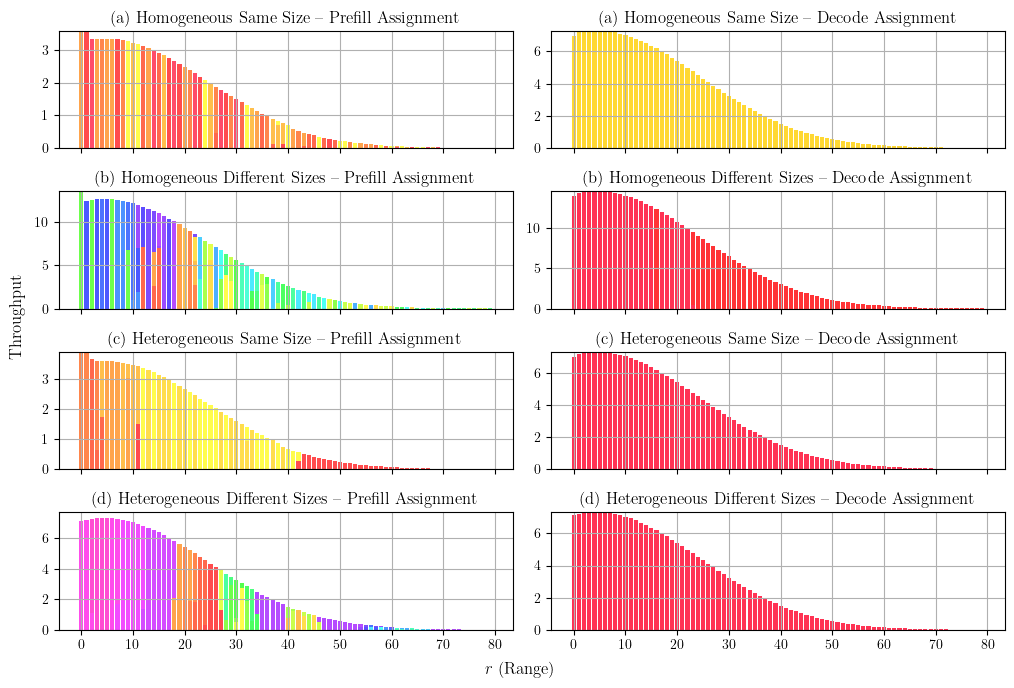

In [5]:
# Create a 4×2 figure (4 rows, 2 columns), with shared x‐ and y‐axes
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(10, 7))

for idx, inventory in enumerate(test_inventories):
    # 1) Load CSV for this inventory
    assignment_df = pd.read_csv(
        f"../data/inner/eval_{inventory['name']}/model_assignment.csv"
    )

    # 2) Build pivot tables for “Prefill_Assignment_Benchmark” and “Decode_Assignment_Benchmark”
    prefill_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Prefill_Assignment_Benchmark',
        aggfunc='sum',
        fill_value=0
    )
    decode_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Decode_Assignment_Benchmark',
        aggfunc='sum',
        fill_value=0
    )

    # 3) Count islands and reset the color cycle so we have one distinct color per island
    num_islands = len(prefill_df.columns)
    print(f"Number of islands in inventory {inventory['name']}: {num_islands}")
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=plt.cm.gist_rainbow(np.linspace(0, 1, num_islands))
    )

    x = prefill_df.index  # ranges

    # 4a) Plot “Prefill_Assignment_Benchmark” in the left column
    ax_prefill = axes[idx, 0]
    bottom = None
    for isl in prefill_df.columns:
        ax_prefill.bar(
            x,
            prefill_df[isl],
            bottom=bottom,
            label=isl,
            alpha=0.7
        )
        bottom = prefill_df[isl] if bottom is None else bottom + prefill_df[isl]

    ax_prefill.set_title(f"{inventory['title']} – Prefill Assignment")
    ax_prefill.grid(True)

    # 4b) Plot “Decode_Assignment_Benchmark” in the right column
    ax_decode = axes[idx, 1]
    bottom = None
    for isl in decode_df.columns:
        ax_decode.bar(
            x,
            decode_df[isl],
            bottom=bottom,
            label=isl,
            alpha=0.8
        )
        bottom = decode_df[isl] if bottom is None else bottom + decode_df[isl]

    ax_decode.set_title(f"{inventory['title']} – Decode Assignment")
    ax_decode.grid(True)

fig.text(0.5, -0.01, r'$r$ (Range)', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}""throughput_all_inventories.pdf",bbox_inches='tight')

Number of islands in inventory homogeneous: 8
Number of islands in inventory homogeneous-different: 30
Number of islands in inventory heterogeneous-same: 8
Number of islands in inventory heterogeneous-different: 34


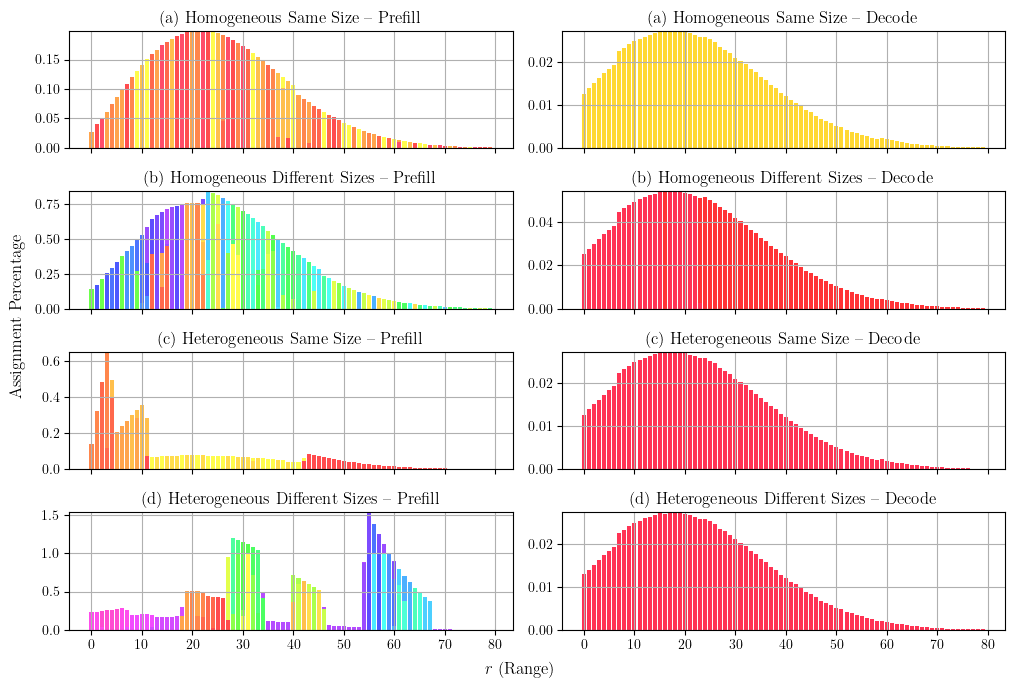

In [6]:
fig, axes = plt.subplots(4, 2, sharex=True, figsize=(10, 7))

for idx, inventory in enumerate(test_inventories):
    # 1) Load CSV for this inventory
    assignment_df = pd.read_csv(
        f"../data/inner/eval_{inventory['name']}/model_assignment.csv"
    )

    # 2) Build pivot tables for “Prefill_Assignment” and “Decode_Assignment”
    prefill_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Prefill_Assignment',
        aggfunc='sum',
        fill_value=0
    )
    decode_df = assignment_df.pivot_table(
        index='Range',
        columns='Island',
        values='Decode_Assignment',
        aggfunc='sum',
        fill_value=0
    )

    # 3) Count islands and reset the color cycle so each island gets a distinct color
    num_islands = len(prefill_df.columns)
    print(f"Number of islands in inventory {inventory['name']}: {num_islands}")
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=plt.cm.gist_rainbow(np.linspace(0, 1, num_islands))
    )

    x = prefill_df.index  # the Range values

    # 4a) Plot “Prefill_Assignment” in the left column
    ax_prefill = axes[idx, 0]
    bottom = None
    for isl in prefill_df.columns:
        ax_prefill.bar(
            x,
            prefill_df[isl],
            bottom=bottom,
            label=isl,
            alpha=0.7
        )
        bottom = prefill_df[isl] if bottom is None else bottom + prefill_df[isl]
    ax_prefill.set_title(f"{inventory['title']} – Prefill")
    ax_prefill.grid(True)

    # 4b) Plot “Decode_Assignment” in the right column
    ax_decode = axes[idx, 1]
    bottom = None
    for isl in decode_df.columns:
        ax_decode.bar(
            x,
            decode_df[isl],
            bottom=bottom,
            label=isl,
            alpha=0.8
        )
        bottom = decode_df[isl] if bottom is None else bottom + decode_df[isl]
    ax_decode.set_title(f"{inventory['title']} – Decode")
    ax_decode.grid(True)

fig.text(0.5, -0.01, r'$r$ (Range)', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Assignment Percentage', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}""assignment_all_inventories.pdf",bbox_inches='tight')